# New Dataset from AVATAR Cerema
https://avatar.cerema.fr/documentation/donnees-accessibles

## Imports

In [1]:
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt

## 1 Analyse

### <font color='#FFA000'>1-1 Test on a sample</font>

In [2]:
sensor_test = pd.read_csv("../dataset/97_measures.csv", sep=";")

In [3]:
sensor_test.head(1)

,count_point_id,measure_datetime,veh_nb,occupancy[%],speed[km/h],flow_confidence,occupancy_confidence,speed_confidence
0,97,2017-01-01T00:00:00+00:00,306,NaN,NaN,A,NaN,NaN


In [4]:
sensor_test_crop = pd.DataFrame(sensor_test, columns=["count_point_id", "measure_datetime", "veh_nb"])

In [5]:
sensor_test_crop.tail(1)

,count_point_id,measure_datetime,veh_nb
173322,97,2023-07-17T00:00:00+00:00,9


### <font color='#FFA000'>1-2 Analyse All</font>

In [6]:
measures = {}
for path in glob('../dataset/*'):
    id_sensor = pd.read_csv(path, sep=";").head(1)["count_point_id"].item()
    measures[id_sensor] = pd.read_csv(path, sep=";", usecols=["measure_datetime", "veh_nb"])

In [7]:
# for measure_key in measures:
#     display((measures[measure_key].head(1)))

### <font color='#FFA000'>2 Preprocessing</font>

In [8]:
measures[97].dtypes

measure_datetime    object
veh_nb               int64
dtype: object

<font color='#0000FF'>Convert measure_datetime to datetime type</font>
</br>
<font color='#0000FF'>Use the measure_datetime as index</font>


In [9]:
for measure_key in measures:
    measures[measure_key]["measure_datetime"] = pd.to_datetime(measures[measure_key]["measure_datetime"], format='%Y-%m-%dT%H:%M:%S%z')
    measures[measure_key].index = measures[measure_key]["measure_datetime"]
    #measures[measure_key].drop(columns=["measure_datetime"], inplace=True)

In [10]:
measures[97].dtypes
display(measures[97].head(1))

,measure_datetime,veh_nb
measure_datetime,,
2017-01-01 00:00:00+00:00,2017-01-01 00:00:00+00:00,306


<font color='#0000FF'>Check if all the sensors have the same time steps (e.g 6min, 1h, 2h), in the same order</font>

In [11]:
time_diffs = []
for measure_key in measures:
    time_diffs.append(measures[measure_key]["measure_datetime"].diff().unique().dropna())

first_time = time_diffs[0]
not_cool = False
for i in range(1, len(time_diffs), 1):
    for x, y in zip(time_diffs[i], first_time):
        if x != y:
            not_cool = True
            # print("Found a sensors measurement with differents interval order or differents inteval")
            # display(time_diffs[i])
            # display(first_time)
if not_cool:
    print("Found at least sensor measurement with differents interval order or differents inteval")

Found at least sensor measurement with differents interval order or differents inteval


<font color='#0000FF'>Check if all the time series have the same length</font>

In [12]:
lengths = []
for measure_key in measures:
    lengths.append(len(measures[measure_key]))

first_length = lengths[0]
not_cool = False
for i in range(1, len(lengths), 1):
    if first_length != lengths[i]:
        not_cool = True
        # print("Not good found differents length of dataset between sensors")
        # print(lengths[i])
        # print(first_length)
if not_cool:
    print("Not good found differents length of dataset between sensors")

Not good found differents length of dataset between sensors


In [13]:
def get_indexes_value_interval(serie, minute):
    # Calculate the time differences between consecutive rows
    time_diffs = serie.diff()
    # Define the threshold for detecting changes in interval (you can adjust this threshold as needed)
    interval_change_threshold = pd.Timedelta(minute)

    # Find the indices where the time difference exceeds the threshold (indicating a change in interval)
    return time_diffs[time_diffs == interval_change_threshold].index


<font color='#0000FF'>Show the differents time steps that exists</font>

In [14]:
intervals = measures[97]["measure_datetime"].diff().unique().dropna()
intervals

<TimedeltaArray>
['0 days 01:00:00', '0 days 00:06:00', '0 days 00:05:24', '0 days 00:00:36',
 '0 days 00:04:48', '0 days 00:01:12', '0 days 00:04:12', '0 days 00:01:48',
 '0 days 00:03:36', '0 days 00:02:24', '0 days 00:03:00']
Length: 11, dtype: timedelta64[ns]

<font color='#0000FF'>Check how many values each time steps have</font>

In [15]:
for interval in intervals:
    indexes = get_indexes_value_interval(measures[97]["measure_datetime"], interval)
    print(f"{interval} | nb_value = {len(measures[97][measures[97].index.isin(indexes)])}")

0 days 01:00:00 | nb_value = 44819
0 days 00:06:00 | nb_value = 121361
0 days 00:05:24 | nb_value = 731
0 days 00:00:36 | nb_value = 734
0 days 00:04:48 | nb_value = 799
0 days 00:01:12 | nb_value = 801
0 days 00:04:12 | nb_value = 791
0 days 00:01:48 | nb_value = 792
0 days 00:03:36 | nb_value = 836
0 days 00:02:24 | nb_value = 836
0 days 00:03:00 | nb_value = 822


<font color='#0000FF'>Drop measure_datetime</font>

In [16]:
for measure_key in measures:
    measures[measure_key].drop(columns=["measure_datetime"], inplace=True)

<font color='#0000FF'>Describe()</font>

In [17]:
measures[97].describe()

,veh_nb
count,173323.000000
mean,432.330250
std,743.830082
min,0.000000
25%,50.000000
50%,182.000000
75%,282.000000
max,4766.000000


In [18]:
measures[97][measures[97]["veh_nb"] > 1000]

,veh_nb
measure_datetime,
2017-01-01 11:00:00+00:00,1067
2017-01-01 12:00:00+00:00,1080
2017-01-01 13:00:00+00:00,1410
2017-01-01 14:00:00+00:00,1833
2017-01-01 15:00:00+00:00,2166
...,...
2022-02-11 07:00:00+00:00,1774
2022-02-11 08:00:00+00:00,1433
2022-02-11 09:00:00+00:00,1848


<font color='#0000FF'>Plot line chart</font>

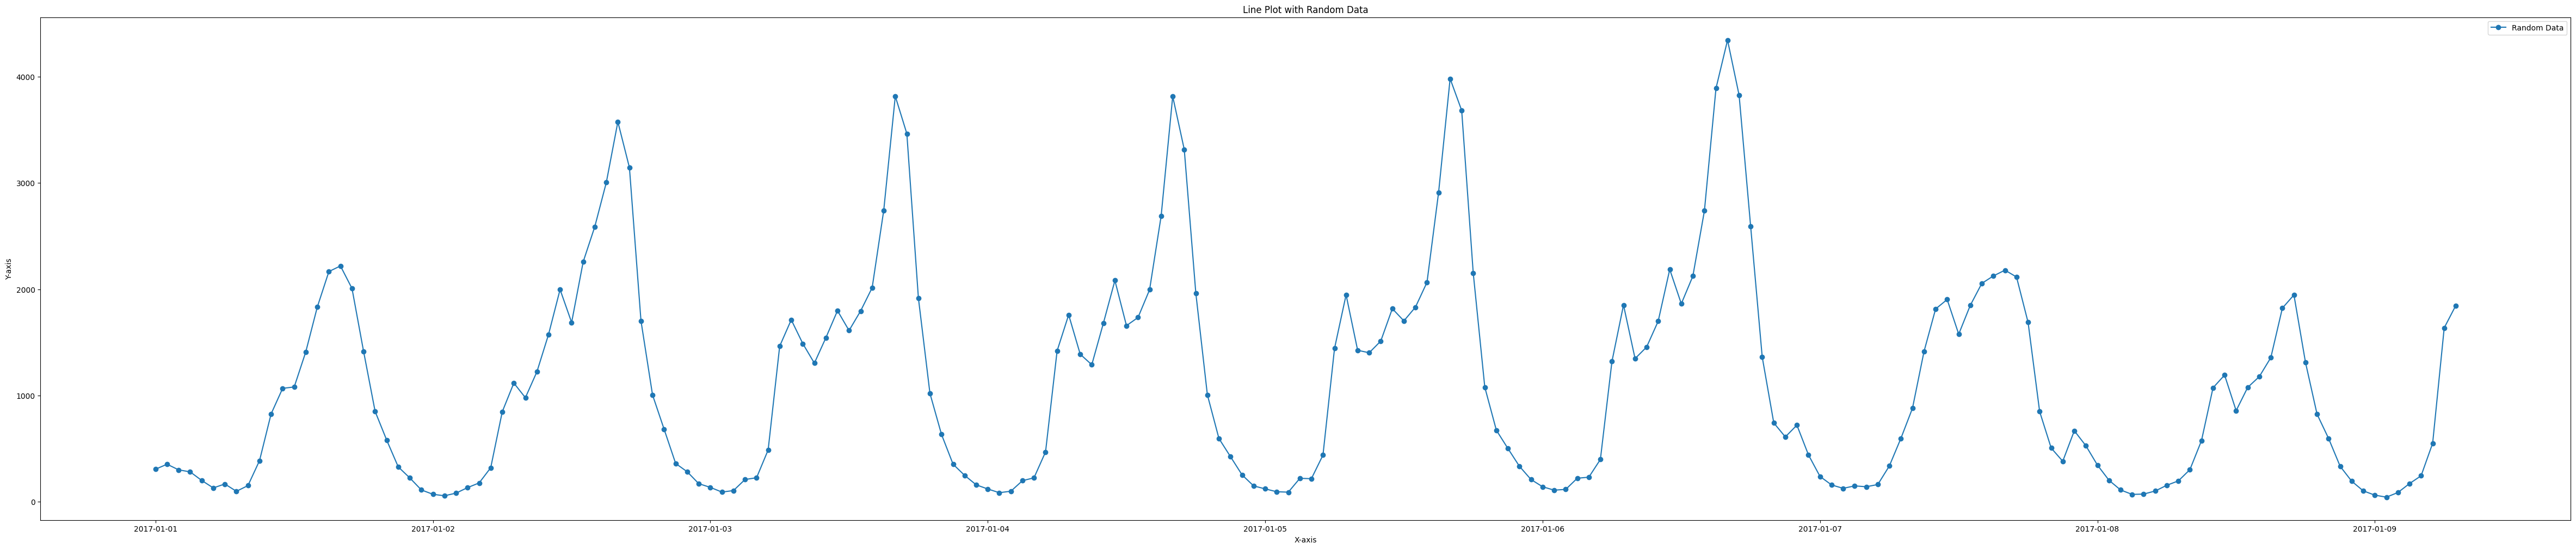

In [19]:
plt.figure(figsize=(60, 12))  # Set the width to 12 inches and height to 6 inches
plt.plot(measures[97].index[:200], measures[97]["veh_nb"][:200], marker='o', linestyle='-', label='Random Data')
# Add title and axis labels
plt.title('Line Plot with Random Data')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Show the legend
plt.legend()

# Show the plot
plt.show()

<font color='#0000FF'>Resample</font>

In [20]:
test_resample = measures[111].resample('5T').interpolate(method="polynomial", order=5)

In [21]:
display(test_resample)

,veh_nb
measure_datetime,
2017-01-01 00:00:00+00:00,184.000000
2017-01-01 00:05:00+00:00,182.152096
2017-01-01 00:10:00+00:00,182.534678
2017-01-01 00:15:00+00:00,184.819329
2017-01-01 00:20:00+00:00,188.699197
...,...
2023-07-16 23:40:00+00:00,17.776217
2023-07-16 23:45:00+00:00,20.464855
2023-07-16 23:50:00+00:00,21.100431


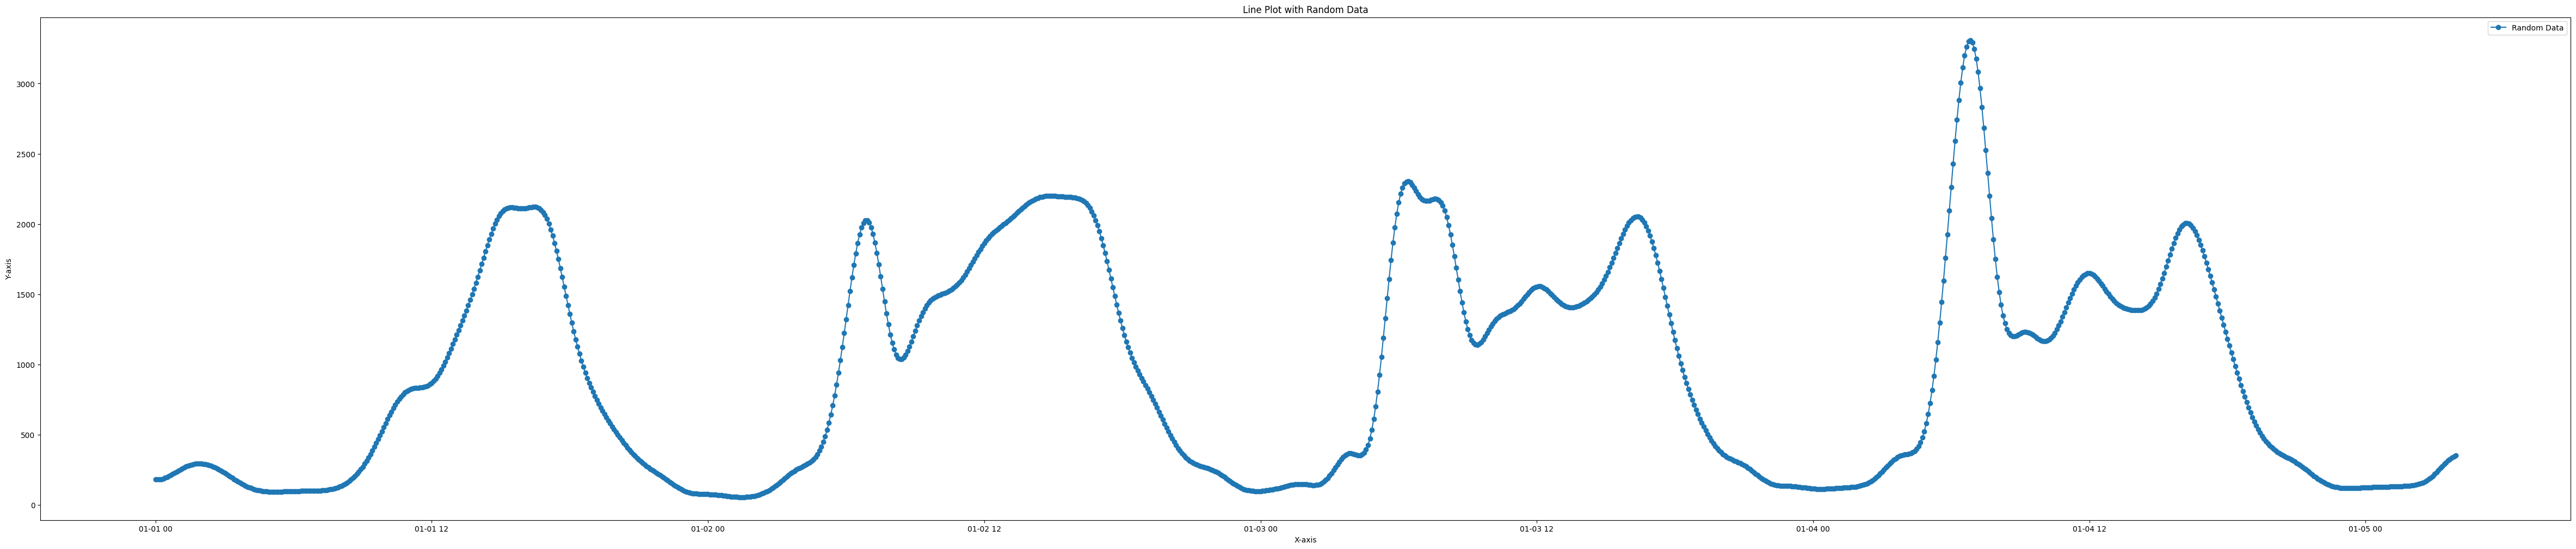

In [22]:
plt.figure(figsize=(60, 12))  # Set the width to 12 inches and height to 6 inches
plt.plot(test_resample.index[:1200], test_resample["veh_nb"][:1200], marker='o', linestyle='-', label='Random Data')
# Add title and axis labels
plt.title('Line Plot with Random Data')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Show the legend
plt.legend()

# Show the plot
plt.show()

In [23]:
for measure_key in measures:
    measures[measure_key] = measures[measure_key].resample('5T').interpolate(method="polynomial", order=5)

In [29]:
for measure_key in measures:
    measures[measure_key].rename(columns={"veh_nb": f"{measure_key}"}, inplace=True)

In [44]:
final_df = measures[97]
for measure_key in measures:
    if measure_key != 97:
        final_df = final_df.merge(measures[measure_key], left_index=True, right_index=True, how='inner')

In [45]:
final_df

,97,111,112,115,116,117,118,121,122,123,...,151,154,156,157,180,393,394,397,403,98
measure_datetime,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00+00:00,306.000000,184.000000,236.000000,167.000000,209.000000,253.000000,302.000000,304.000000,386.000000,311.000000,...,231.000000,131.000000,156.000000,190.000000,235.000000,212.000000,252.000000,345.000000,239.000000,221.000000
2017-01-01 00:05:00+00:00,327.390593,182.152096,263.969060,159.625179,236.602192,249.026587,331.347421,324.012863,406.660022,331.208835,...,260.652252,136.711705,175.053047,215.559952,244.478753,209.881315,282.733506,369.417221,232.781454,233.696327
2017-01-01 00:10:00+00:00,343.781701,182.534678,284.281630,155.494371,256.555302,248.149527,353.978875,341.805394,422.870417,348.914721,...,283.002852,141.084676,188.935941,234.161987,252.470448,209.655902,305.382232,388.155717,228.744601,244.380478
2017-01-01 00:15:00+00:00,355.828439,184.819329,298.156122,154.126862,270.081803,249.883467,370.906388,357.565490,435.280338,364.372221,...,299.143789,144.394090,198.527772,246.909152,259.047847,211.044218,321.221572,402.040997,226.603585,253.372090
2017-01-01 00:20:00+00:00,364.134836,188.699197,306.697489,155.078625,278.290809,253.779538,383.047455,371.465917,444.478007,377.813428,...,310.069386,146.882836,204.621132,254.802311,264.287294,213.785743,331.408159,411.823010,226.090522,260.953583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-16 23:40:00+00:00,11.961028,17.776217,13.557648,47.906479,42.606575,8.933773,8.932377,22.462690,9.714612,36.249154,...,9.393958,22.700284,13.782974,8.558842,17.475888,7.519294,7.472769,24.834586,18.635185,9.546177
2023-07-16 23:45:00+00:00,12.614016,20.464855,14.442096,64.321835,56.755267,6.194485,6.192491,25.153196,6.288365,49.112160,...,8.895723,28.748510,16.608361,8.267237,22.227926,5.180885,5.114438,31.396077,24.485443,9.166418
2023-07-16 23:50:00+00:00,12.628651,21.100431,14.437029,69.821113,61.449676,3.404448,3.402240,25.326700,2.966487,61.298376,...,8.378573,30.556127,19.272040,8.090413,23.719271,2.810351,2.736811,37.733977,30.089552,8.814362


In [46]:
final_df = final_df.to_numpy()
np.savez('dataset_Rennes.npz', data=final_df)

In [24]:
# for measure_key in measures:
#     measures[measure_key]["measure_datetime"] = measures[measure_key].index